In [ ]:
# Import necessary libraries
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from google.auth.transport.requests import Request
from google.auth.credentials import AnonymousCredentials
from google.oauth2.service_account import Credentials
from google.cloud import bigquery
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nth-victory-359310-450e996fc246.json to nth-victory-359310-450e996fc246.json


In [ ]:
# Authenticate to Google Cloud
auth.authenticate_user()
credentials, project_id = default()
project_id = 'nth-victory-359310'

# Use the JSON key file to authenticate
creds = Credentials.from_service_account_file('nth-victory-359310-450e996fc246.json')

# Create BigQuery client
client = bigquery.Client(credentials=creds, project=project_id)

# Define the SQL query
query = """
  SELECT
      oi.id AS order_item_id,
      o.order_id,
      oi.product_id,
      oi.inventory_item_id,
      p.category,
      p.name AS product_name,
      brand,
      p.department,
      o.created_at,
      o.status,
      oi.sale_price,
      p.cost,
      oi.user_id,
      u.age,
      u.gender,
      u.state,
      u.country
  FROM
      `bigquery-public-data.thelook_ecommerce.orders` AS o
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi-- combine data from order_items
      ON o.order_id = oi.order_id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.users` AS u -- receive user profile
      ON oi.user_id = u.id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` AS p -- receive product info
      ON oi.product_id = p.id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii -- receive inventory info
      ON oi.inventory_item_id = ii.id
  ORDER BY
      o.created_at DESC;
  """
# Query the data and convert to DataFrame
df_raw = client.query(query).to_dataframe()

In [ ]:
# Display information about the DataFrame
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181036 entries, 0 to 181035
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   order_item_id      181036 non-null  Int64              
 1   order_id           181036 non-null  Int64              
 2   product_id         181036 non-null  Int64              
 3   inventory_item_id  181036 non-null  Int64              
 4   category           181036 non-null  object             
 5   product_name       181024 non-null  object             
 6   brand              180877 non-null  object             
 7   department         181036 non-null  object             
 8   created_at         181036 non-null  datetime64[us, UTC]
 9   status             181036 non-null  object             
 10  sale_price         181036 non-null  float64            
 11  cost               181036 non-null  float64            
 12  user_id            181036 non-

In [ ]:
# Create a copy of df_raw
df = df_raw.copy()
df.head()

,order_item_id,order_id,product_id,inventory_item_id,category,product_name,brand,department,created_at,status,sale_price,cost,user_id,age,gender,state,country
0,171616,118340,12715,463599,Swim,Shoshanna Women's Solid Ruched One Piece,Shoshanna,Women,2024-08-06 19:18:37.654781+00:00,Processing,180.000000,79.200000,94809,36,F,Île-de-France,France
1,134033,92282,20938,362035,Jeans,Armani Exchange J130 - Sateen Skinny Jean,A:X Armani Exchange,Men,2024-08-06 19:16:43.646514+00:00,Processing,98.000000,49.882000,73780,51,M,Rio de Janeiro,Brasil
2,38855,26775,13692,105104,Accessories,Ear Warmers Stretch Fleece Tahoe,180s,Women,2024-08-06 18:58:04.904424+00:00,Processing,30.000000,12.180000,21440,31,F,Florida,United States
3,38854,26775,15513,105101,Plus,Levi's Women's 512 Plus-Size Skinny Jean,Levi's,Women,2024-08-06 18:58:04.904424+00:00,Processing,47.990002,25.386711,21440,31,F,Florida,United States
4,121387,83634,10786,327985,Intimates,Jezebel Women's Lacy Girl Cheeky Hipster,Jezebel,Women,2024-08-06 18:58:01.046470+00:00,Cancelled,10.000000,4.910000,66852,19,F,Hessen,Germany


In [ ]:
# checking null in product_name
df[df['brand'].isnull()]

,order_item_id,order_id,product_id,inventory_item_id,category,product_name,brand,department,created_at,status,sale_price,cost,user_id,age,gender,state,country
2480,132240,91042,15757,357209,Plus,NEW Aluminum Credit Card Wallet - RFID Blockin...,None,Women,2024-08-04 12:39:00+00:00,Processing,4.210000,2.23551,72751,54,F,Hebei,China
3819,60568,41775,1629,163695,Fashion Hoodies & Sweatshirts,Carhartt Women's Hooded Knit Jacket,None,Women,2024-08-04 00:45:56.084075+00:00,Processing,45.950001,23.57235,33394,65,F,Western Australia,Australia
4060,13310,9145,9482,36059,Socks & Hosiery,KEEN Women Bellingham Low Ultralite Sock,None,Women,2024-08-03 17:09:56.665009+00:00,Shipped,16.000000,5.71200,7379,44,F,Zhejiang,China
4827,50578,34817,25135,136721,Socks,Volcom Men's Argyle Socks,None,Men,2024-08-03 06:45:00+00:00,Complete,22.480000,12.47640,27815,41,M,Comunidad de Madrid,Spain
4921,32042,22041,13863,86635,Accessories,Husky Animal Hat with Mittens,None,Women,2024-08-03 05:35:12.555751+00:00,Complete,24.250000,9.55450,17609,44,F,Guizhou,China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178022,159105,109577,10598,429806,Intimates,JMS Comfort Lace with Hidden Shaper,None,Women,2019-12-30 11:22:00+00:00,Complete,16.580000,9.61640,87722,38,F,Wisconsin,United States
178400,154188,106218,16309,416461,Tops & Tees,Hurley Men's One and Only Short Sleeve Tee,None,Men,2019-12-07 07:52:00+00:00,Shipped,20.000000,11.52000,84926,69,M,Tianjin,China
178987,88173,60839,11843,238086,Intimates,Wendy Glez Rose Cami Black,None,Women,2019-10-26 16:07:00+00:00,Processing,60.000000,33.90000,48645,62,F,São Paulo,Brasil
179033,138292,95261,25135,373549,Socks,Volcom Men's Argyle Socks,None,Men,2019-10-21 17:51:00+00:00,Cancelled,22.480000,12.47640,76153,31,M,California,United States


# Pre-Processing

In [ ]:
# Checking duplicates
df.duplicated().sum()

0

In [ ]:
# Checking Nilai Null
df.isnull().sum()

order_item_id          0
order_id               0
product_id             0
inventory_item_id      0
category               0
product_name          12
brand                159
department             0
created_at             0
status                 0
sale_price             0
cost                   0
user_id                0
age                    0
gender                 0
state                  0
country                0
dtype: int64

To handle null values in the product_name and brand columns, I will fill them using the product_name that matches the existing product_id. If they remain null, I will fill them with 'No Product Name' and 'No Brand'.

In [ ]:
# Mengisi nilai null pada 'product_name' berdasarkan 'product_id'
df['product_name'] = df.groupby('product_id')['product_name'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Product Name'))


In [ ]:
df['brand'] = df.groupby('product_id')['brand'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Brand'))

I’m filtering out data with 'cancelled' and 'returned' statuses because these statuses do not affect the company's revenue.

In [ ]:
df = df[~df['status'].isin(['Cancelled', 'Returned'])]


In [ ]:
df.head()

,order_item_id,order_id,product_id,inventory_item_id,category,product_name,brand,department,created_at,status,sale_price,cost,user_id,age,gender,state,country
0,171616,118340,12715,463599,Swim,Shoshanna Women's Solid Ruched One Piece,Shoshanna,Women,2024-08-06 19:18:37.654781+00:00,Processing,180.000000,79.200000,94809,36,F,Île-de-France,France
1,134033,92282,20938,362035,Jeans,Armani Exchange J130 - Sateen Skinny Jean,A:X Armani Exchange,Men,2024-08-06 19:16:43.646514+00:00,Processing,98.000000,49.882000,73780,51,M,Rio de Janeiro,Brasil
2,38855,26775,13692,105104,Accessories,Ear Warmers Stretch Fleece Tahoe,180s,Women,2024-08-06 18:58:04.904424+00:00,Processing,30.000000,12.180000,21440,31,F,Florida,United States
3,38854,26775,15513,105101,Plus,Levi's Women's 512 Plus-Size Skinny Jean,Levi's,Women,2024-08-06 18:58:04.904424+00:00,Processing,47.990002,25.386711,21440,31,F,Florida,United States
6,119352,82234,1472,322503,Sweaters,Volcom Juniors Catfight Cardigan,Volcom,Women,2024-08-06 18:57:44.410715+00:00,Shipped,79.449997,37.103149,65714,68,F,Victoria,Australia


# Exploratory Data Analysis

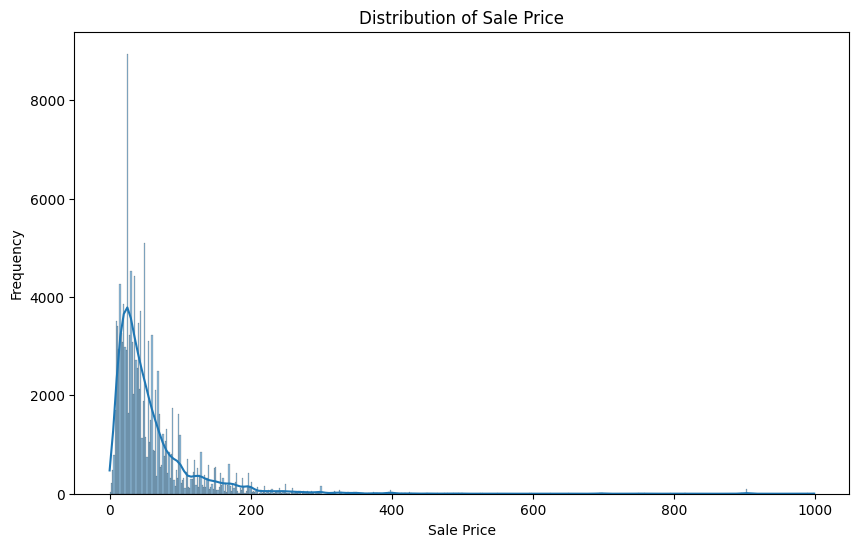

In [ ]:
# Distribution of 'sale_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['sale_price'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()


Based on the chart above, most transactions have a relatively low purchase price (0 - 100).

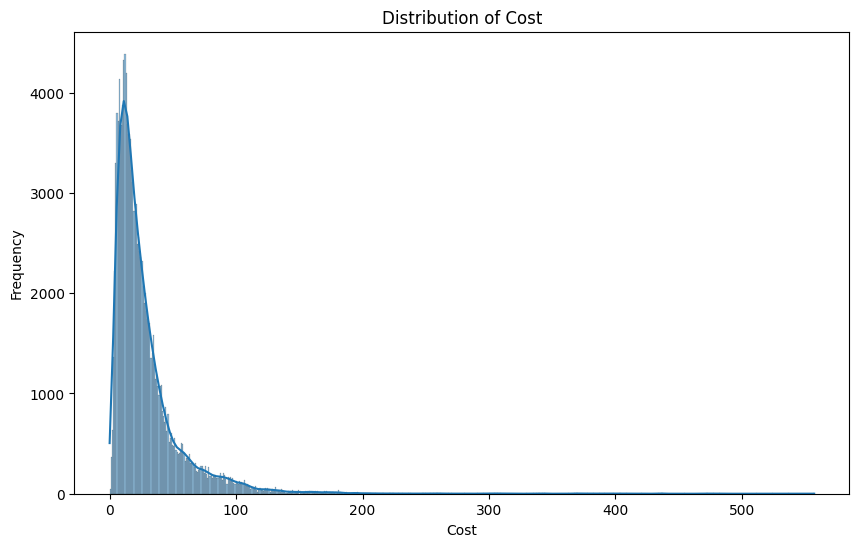

In [ ]:
# Distribution of 'sale_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['cost'], kde=True)
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

Based on the chart above, most transactions have a relatively low cost price (0 - 100).

<ipython-input-22-cbdd7d3ee28d>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['created_at'].dt.to_period('M')


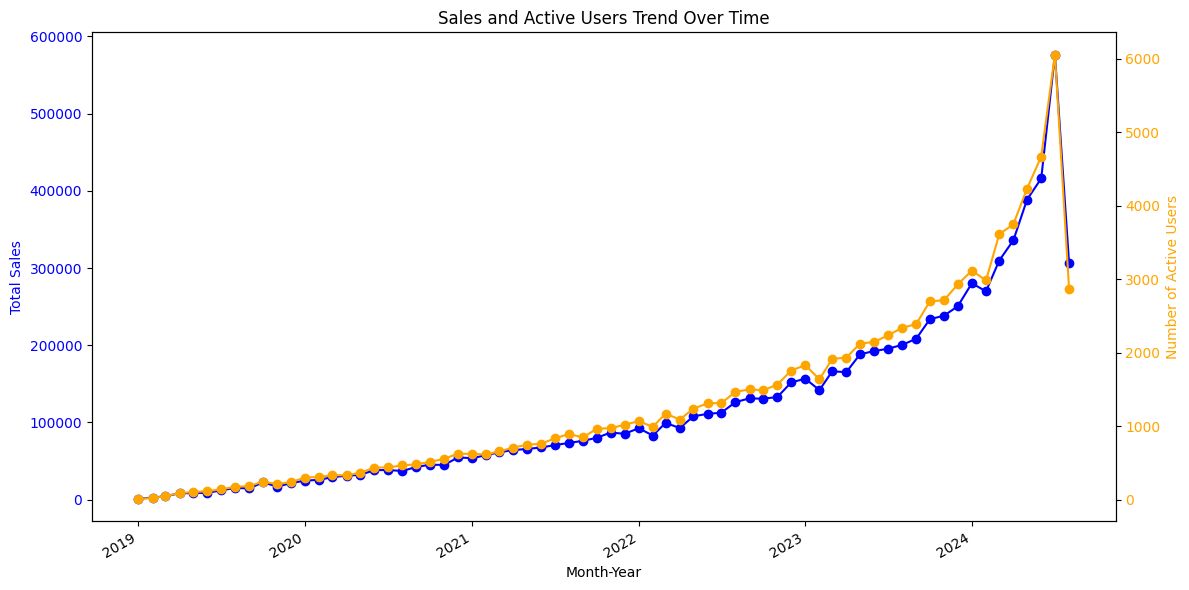

In [ ]:
# Convert 'created_at' to datetime and extract month-year
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Calculate monthly sales
monthly_sales = df.groupby('month_year')['sale_price'].sum().reset_index()

# Calculate monthly active users
monthly_users = df.groupby('month_year')['user_id'].nunique().reset_index()

# Plotting the trends with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sales trend on primary y-axis
ax1.plot(monthly_sales['month_year'].dt.to_timestamp(), monthly_sales['sale_price'], marker='o', color='b', label='Total Sales')
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Total Sales', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Sales and Active Users Trend Over Time')

# Create secondary y-axis for active users
ax2 = ax1.twinx()
ax2.plot(monthly_users['month_year'].dt.to_timestamp(), monthly_users['user_id'], marker='o', color='orange', label='Active Users')
ax2.set_ylabel('Number of Active Users', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

# Show plot
plt.tight_layout()
plt.show()

Based on the graph, the companie has experienced significant growth in the number of users and orders, with a sharp increase in 2023 and 2024. However, there is a decline in the last month of 2024. This is because the data was taken at the beginning of August 2024, so there is still a possibility that the trend will continue to rise.

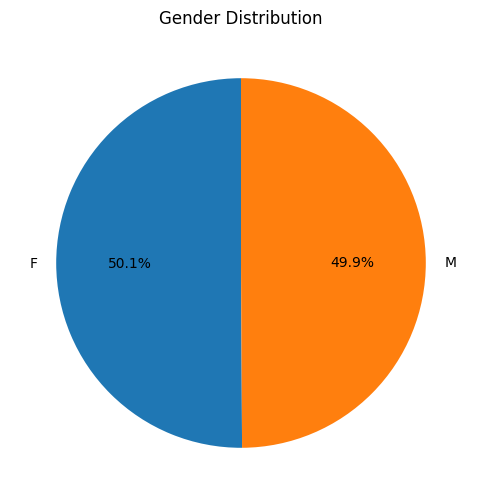

In [ ]:
# Calculate gender distribution
gender_counts = df['gender'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()


The distribution of users by gender is very balanced, with a slight majority of female users. This indicates that the platform has broad and equal appeal to both genders.

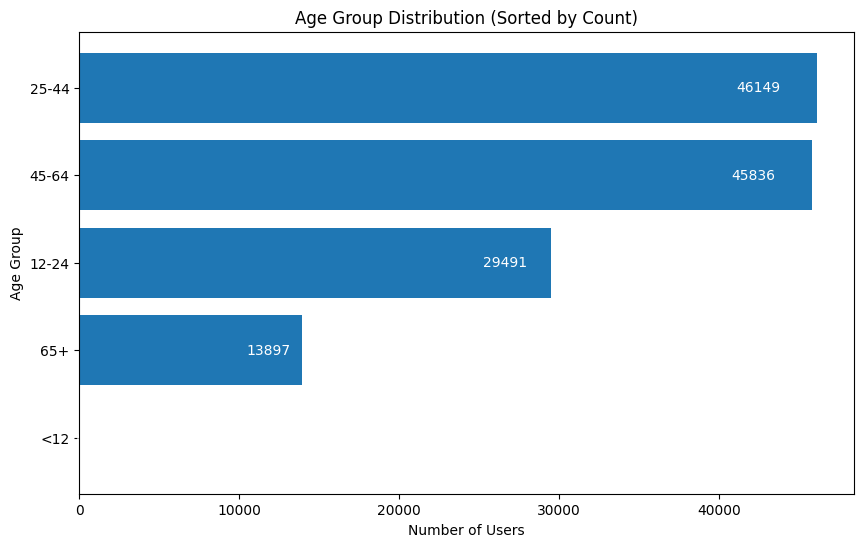

In [ ]:
# Define age groups
age_bins = [0, 12, 25, 45, 65, 100]
age_labels = ['<12', '12-24', '25-44', '45-64', '65+']

# Categorize ages into groups
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate age group distribution
age_group_counts = df['age_group'].value_counts()

# Sort age groups by count in descending order
age_group_counts = age_group_counts.sort_values(ascending=True)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(age_group_counts.index, age_group_counts.values)

# Add data labels inside the bars
for bar in bars:
    plt.text(bar.get_width() - 0.05 * bar.get_width(),  # Position label inside bar, near the end
             bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}',
             va='center',
             ha='right',
             color='white')

plt.xlabel('Number of Users')
plt.ylabel('Age Group')
plt.title('Age Group Distribution (Sorted by Count)')
plt.show()

The majority of customers are in the age range of 25-44.

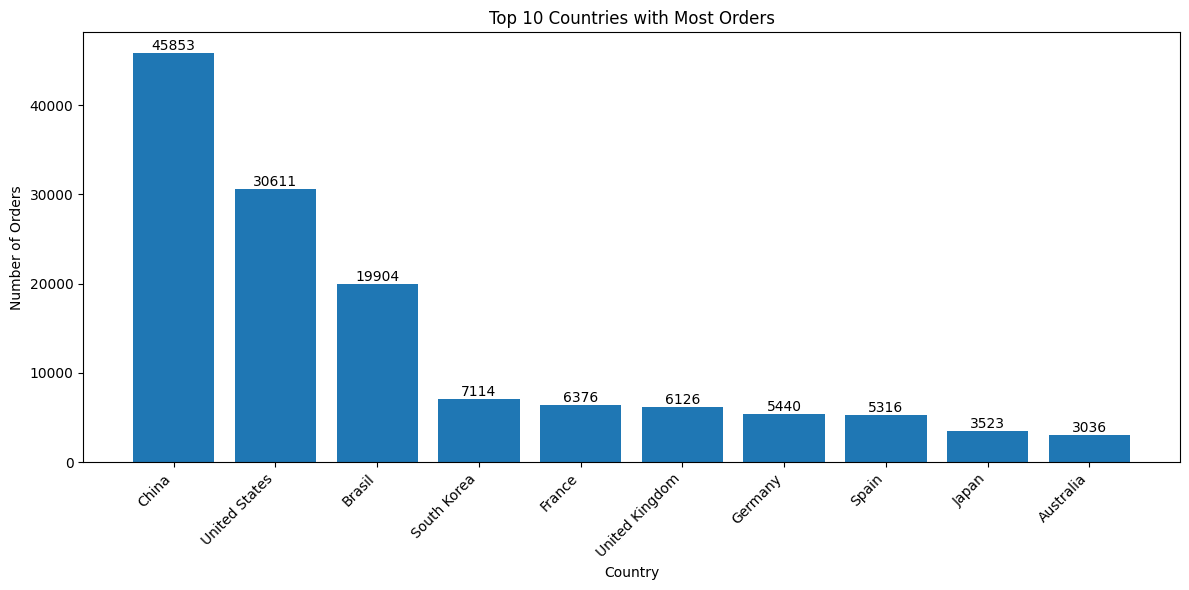

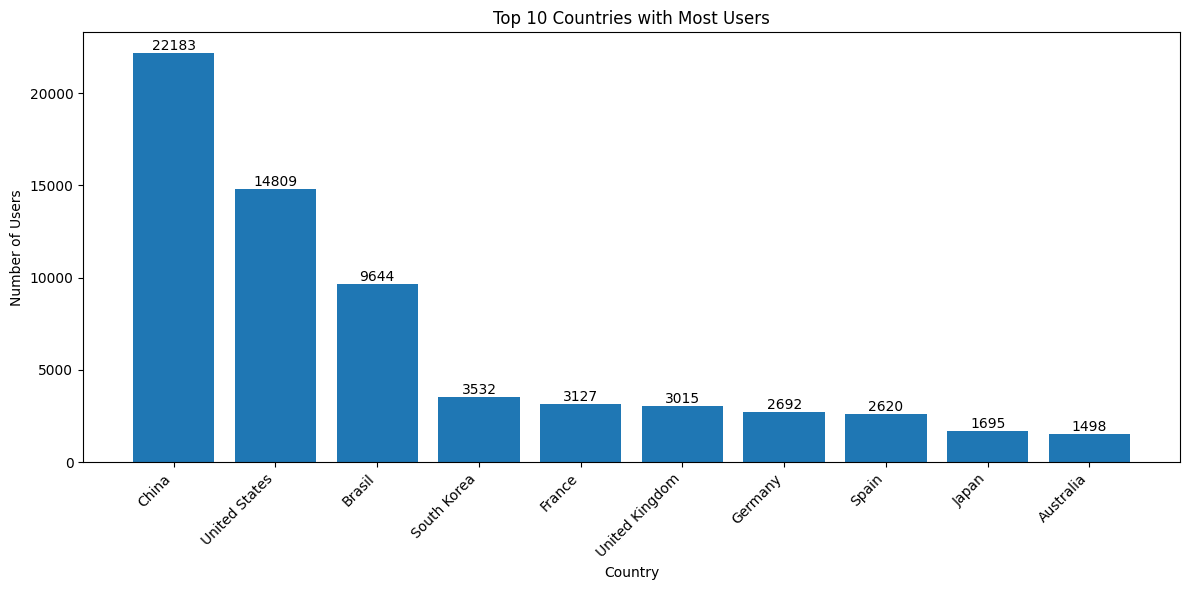

In [ ]:
# Top 10 Countries with Most Orders
top_order_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_order_countries.index, top_order_countries.values)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Top 10 Countries with Most Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top 10 Countries with Most Users
top_user_countries = df.groupby('country')['user_id'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_user_countries.index, top_user_countries.values)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('Top 10 Countries with Most Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


China is the country with the highest number of transactions and users.

# Modelling

## RFM Model

In [ ]:
# Convert 'created_at' to datetime object
df['created_at'] = pd.to_datetime(df['created_at'])

# Set reference date for recency calculation
reference_date = df['created_at'].max() + dt.timedelta(days=1)

# Calculate Recency
df_recency = df.groupby('user_id')['created_at'].max().reset_index()
df_recency['recency'] = (reference_date - df_recency['created_at']).dt.days

# Calculate Frequency
df_frequency = df.groupby('user_id')['order_id'].nunique().reset_index()
df_frequency.rename(columns={'order_id': 'frequency'}, inplace=True)

# Calculate Monetary
df_monetary = df.groupby('user_id')['sale_price'].sum().reset_index()
df_monetary.rename(columns={'sale_price': 'monetary'}, inplace=True)

# Merge RFM values into a single DataFrame
df_rfm = df_recency.merge(df_frequency, on='user_id').merge(df_monetary, on='user_id')
df_rfm

,user_id,created_at,recency,frequency,monetary
0,1,2024-07-30 12:41:00+00:00,8,1,50.000000
1,2,2024-05-30 07:30:00+00:00,69,1,17.500000
2,4,2024-08-04 13:12:16.467506+00:00,3,1,5.990000
3,5,2024-08-03 06:15:16.485210+00:00,4,1,88.000000
4,6,2023-06-30 03:37:00+00:00,404,1,48.950001
...,...,...,...,...,...
65843,99990,2024-05-27 12:50:00+00:00,72,1,42.799999
65844,99995,2024-05-26 13:39:00+00:00,73,1,74.990002
65845,99997,2024-07-16 17:44:00+00:00,22,1,83.309998
65846,99998,2024-08-01 06:09:00+00:00,6,1,39.880001


## K-Means Clustering

In [ ]:
# Normalize the RFM data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(df_rfm[['recency', 'frequency', 'monetary']])

In [ ]:
# Try different numbers of clusters (2 to 5)
for n_clusters in range(2, 6):
  # Initialize KMeans model
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)

  # Fit the model to the normalized RFM data
  kmeans.fit(rfm_normalized)

  # Get cluster labels for each customer
  cluster_labels = kmeans.predict(rfm_normalized)

  # Add cluster labels to the RFM DataFrame
  df_rfm[f'cluster_{n_clusters}'] = cluster_labels

df_rfm.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

,user_id,created_at,recency,frequency,monetary,cluster_2,cluster_3,cluster_4,cluster_5
0,1,2024-07-30 12:41:00+00:00,8,1,50.000000,1,2,1,3
1,2,2024-05-30 07:30:00+00:00,69,1,17.500000,1,2,1,3
2,4,2024-08-04 13:12:16.467506+00:00,3,1,5.990000,1,2,1,3
3,5,2024-08-03 06:15:16.485210+00:00,4,1,88.000000,1,2,1,3
4,6,2023-06-30 03:37:00+00:00,404,1,48.950001,1,2,1,3


## Evaluation Metrics

In [ ]:
# Iterate over the cluster solutions (2 to 5 clusters)
for n_clusters in range(2, 6):
  # Extract cluster labels for the current number of clusters
  cluster_labels = df_rfm[f'cluster_{n_clusters}']

  # Calculate Silhouette Score
  silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
  print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

  # Calculate Davies-Bouldin Index
  davies_bouldin = davies_bouldin_score(rfm_normalized, cluster_labels)
  print(f"For n_clusters = {n_clusters}, the Davies-Bouldin index is : {davies_bouldin}")

  print("-" * 50)


For n_clusters = 2, the average silhouette_score is : 0.4234085698569811
For n_clusters = 2, the Davies-Bouldin index is : 1.101310907322273
--------------------------------------------------
For n_clusters = 3, the average silhouette_score is : 0.4095428440606898
For n_clusters = 3, the Davies-Bouldin index is : 0.9104399840805719
--------------------------------------------------
For n_clusters = 4, the average silhouette_score is : 0.43119870319813136
For n_clusters = 4, the Davies-Bouldin index is : 0.9664687391697548
--------------------------------------------------
For n_clusters = 5, the average silhouette_score is : 0.43241732182297266
For n_clusters = 5, the Davies-Bouldin index is : 0.9274996325947459
--------------------------------------------------


Based on evaluate, K-optimal is 3 because there have the lowest average silhouette score and the lowest Davies-Bouldin index. So, we can choose the model with 3 cluster

## Customer Segmentation

In [ ]:
good_model = df_rfm[['recency', 'frequency', 'monetary', 'cluster_3']]

# Menampilkan rata-rata RFM per cluster
cluster_summary = good_model.groupby('cluster_3').mean()
cluster_summary

,recency,frequency,monetary
cluster_3,,,
0,1067.546182,1.117629,88.260504
1,256.477343,2.589265,305.034937
2,236.381975,1.196638,81.477403


That is the average of recency, frequency, and monetary with 3 clusters. So, I have 3 categories for definiting every customer. Here is a refined definition of the three clusters based on the average of recency, frequency, and monetary values:

1.  Cluster 0: Indicates Passive Customers, as they have the highest recency, the lowest frequency, and middle monetary values.
2.  Cluster 1: Indicates Loyal Customers, with middle recency, the highest frequency, and the highest monetary values.
3. Cluster 2: Indicates New Potential Customers, with the lowest recency, middle frequency, and lowest monetary values.

In [ ]:
# Determining cluster descriptions based on RFM characteristics
cluster_descriptions = {
    0: 'Passive Customer',
    1: 'Loyal Customer',
    2: 'New Potential Customer'
}

# Adding cluster descriptions to the data
df_rfm['Customer Segmentation'] = df_rfm['cluster_3'].map(cluster_descriptions)

# Data Fix for RFM Model and Cluster Model
df_rfm_fix = df_rfm.drop(columns=['cluster_2','cluster_4','cluster_5'])
df_rfm_fix.head()

,user_id,created_at,recency,frequency,monetary,cluster_3,Customer Segmentation
0,1,2024-07-30 12:41:00+00:00,8,1,50.000000,2,New Potential Customer
1,2,2024-05-30 07:30:00+00:00,69,1,17.500000,2,New Potential Customer
2,4,2024-08-04 13:12:16.467506+00:00,3,1,5.990000,2,New Potential Customer
3,5,2024-08-03 06:15:16.485210+00:00,4,1,88.000000,2,New Potential Customer
4,6,2023-06-30 03:37:00+00:00,404,1,48.950001,2,New Potential Customer


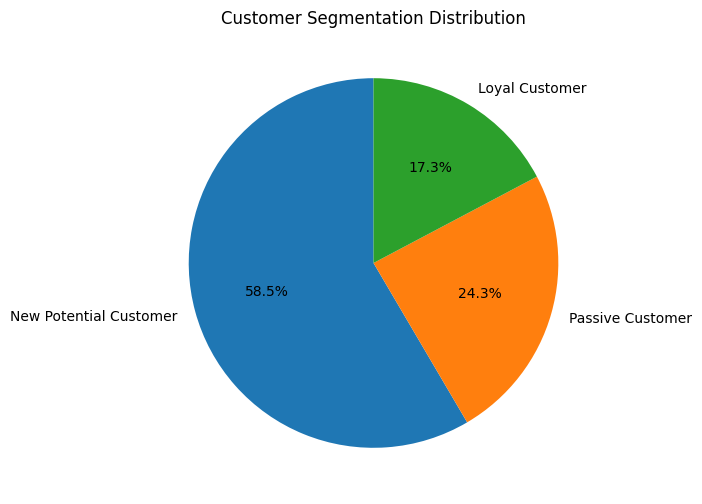

In [ ]:
import matplotlib.pyplot as plt
# Calculate the distribution of customer segments
segment_counts = df_rfm_fix['Customer Segmentation'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Segmentation Distribution')
plt.show()

In [ ]:
# Save the results
df_rfm_fix.to_csv('/content/drive/My Drive/Assignment DA ASTRO_Rozan/The Result of Modeling.csv', index=False)


**RECOMMENDATION**


*   **For Passive Customer**
    1.   The company can offer incentives such as coupons or gifts to encourage repeat purchases.
    2.   The company can run email marketing campaigns to re-engage their attention.
    3.   Offer relevant products or services based on previous purchase history to increase interest and purchase frequency.

*   **For Loyal Customer**
    1.   The company can implement a loyalty program that offers points or discounts to loyal customers.
    2.   The company can take the opportunity to upsell more expensive products or cross-sell additional products. Offer special deals or product bundles.

*   **For New Potential Customer**
    1.   The company can provide education about the products and their benefits through email or valuable content.
    2.   The company can offer promotions that increase transaction value, such as product bundles or discounts for bulk purchases.